# Simulaciones proyecto

En este notebook se desarrollan las simulaciones relacionadas al paper ...

Se busca probar los tests de hipótesis relacionados a la norma $L_1$ y la de $log$-Likelihood.

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [2]:
def samplear(distribution, params):
    return np.concatenate([distribution(**param, size=int(n_samples / len(params))) for param in params])


## Estadístico basado en norma $L_1$

Primero se calcula el test basado en la norma $L_1$. Donde su formulación es:

$$
    L_1(\nu_n, \ \mu_{n,1} \times \mu_{n,2}) =
    \sum_{A\in P_n}\sum_{B\in Q_n} |\nu_n(A\times B) - \mu_{n,1}(A) \cdot \mu_{n,2}(B)|
$$
    
Donde se tiene que dicho estadístico sobrepasa un umbral dado por el test de hipótesis, que está dado por

$$
    L_{n}(\nu_{n}, \mu_{n,1}\times\mu_{n,2})>  c_{1}\left(\sqrt{\frac{m_{n} \cdot m'_{n}}{n}} + \sqrt{\frac{m_{n}}{n}} + \sqrt{\frac{m'_{n}}{n}}\right)  \approx c_{1}\sqrt{\frac{m_{n} \cdot m'_{n}}{n}}
$$

In [3]:
def l1Test(X, Y, mX, mY, plotear=False):
    X = (X - np.mean(X)) / np.std(X)
    Y = (Y - np.mean(Y)) / np.std(Y)

    n_samples = X.shape[0]
    # particionar el espacio y generar los soportes, es decir, los intervalos sobre los que se sumara
    minx = np.min(X)
    maxx = np.max(X)
    dx = maxx - minx

    miny = np.min(Y)
    maxy = np.max(Y)
    dy = maxy - miny

    totalXY = X.shape[0]
    totalX = X.shape[0]
    totalY = Y.shape[0]

    L1 = 0

    # el umbral
    umbral = 1.177 * np.sqrt(mX * mY / n_samples)

    for mx in range(mX):
        ax, bx = [minx + dx * mx / mX,
                  minx + dx * (mx + 1) / mX] # se define intervalo de la particion
        for my in range(mY):
            ay, by = [miny + dy * my / mY,
                      miny + dy * (my + 1) / mY] # se define intervalo de la particion

            intervaloX = np.array([X < bx]) * np.array([X > ax])
            intervaloY = np.array([Y < by]) * np.array([Y > ay])
            c = np.sum(intervaloX[0] * intervaloY[0])

            nuN = c / n_samples
            muNX = np.sum(intervaloX) / n_samples
            muNB = np.sum(intervaloY) / n_samples

            aux = np.abs(nuN - muNX * muNB)
            L1 += aux

            if plotear:
                plt.scatter(x=X[intervaloX[0] * intervaloY[0]],
                            y=Y[intervaloX[0] * intervaloY[0]],
                            cmap="PuOr", alpha=0.1)
                plt.vlines(bx, ymin=miny, ymax=maxy)
                plt.hlines(by, xmin=minx, xmax=maxx)
                plt.text((ax + bx)/2, (ay + by)/2, '{:.2f}'.format(aux))

    
    if plotear:
        print('L1 : {:.4f} umbral {:.4f}'.format(L1, umbral))

        if L1 < umbral: print('son independientes')
        else: print('son dependientes')
        print(mX / np.log(n_samples))
        print(mX * mY / n_samples)
        plt.show()
    return L1, umbral

## Estadístico basado en $log$-verosimilitud

La forma de este estadístico es:

$$
I_n(\nu_n,\mu_{n,1}\times\mu_{n,2}) = \sum_{A\in P_n}\sum_{B\in Q_n}\nu_n(A\times B)\log{\frac{\nu_n(A\times B)}{\mu_{n,1}(A)\cdot\mu_{n,2}(B)}}
$$

donde el umbral está definido por

$$
I_{n}(\nu_{n},\mu_{n,1}\times\mu_{n,2}) \geq \frac{m_nm'_n(\log{(n + m_nm'_n) + 1})}{n}
$$

<!-- $$
I_{n}(\nu_{n},\mu_{n,1}\times\mu_{n,2}) \geq \frac{\Phi^{-1} (1-\alpha) \sqrt{2m_{n} m'_{n}} + m_{n}m'_{n}}{2n}
$$
 -->

In [4]:
def logLikTest(X, Y, mX, mY, plotear=False):
    X = (X - np.mean(X)) / np.std(X)
    Y = (Y - np.mean(Y)) / np.std(Y)
    
    n_samples = X.shape[0]

    # particionar el espacio y generar los soportes, es decir, los intervalos sobre los que se sumara
    minx = np.min(X)
    maxx = np.max(X)
    dx = maxx - minx

    miny = np.min(Y)
    maxy = np.max(Y)
    dy = maxy - miny

    totalXY = X.shape[0]
    totalX = X.shape[0]
    totalY = Y.shape[0]

    I1 = 0

    # el umbral
    umbral = mX * mY * (np.log(n_samples + mX * mY) + 1) / n_samples
    eps = 1e-4

    for mx in range(mX):
        ax, bx = [minx + dx * mx / mX,
                  minx + dx * (mx + 1) / mX] # se define intervalo de la particion
        for my in range(mY):
            ay, by = [miny + dy * my / mY,
                      miny + dy * (my + 1) / mY] # se define intervalo de la particion

            intervaloX = np.array([X < bx]) * np.array([X > ax])
            intervaloY = np.array([Y < by]) * np.array([Y > ay])
            c = np.sum(intervaloX[0] * intervaloY[0])

            nuN = c / n_samples
            muNX = np.sum(intervaloX) / n_samples
            muNB = np.sum(intervaloY) / n_samples

            aux = nuN * np.log(nuN / (muNX * muNB + eps) + eps)
            I1 += aux

            if plotear:
                plt.scatter(x=X[intervaloX[0] * intervaloY[0]],
                            y=Y[intervaloX[0] * intervaloY[0]],
                            cmap="PuOr", alpha=0.1)
                plt.vlines(bx, ymin=miny, ymax=maxy)
                plt.hlines(by, xmin=minx, xmax=maxx)
                plt.text((ax + bx)/2, (ay + by)/2, '{:.2f}'.format(aux))


    if plotear:
        print('I1 : {:.4f} umbral {:.4f}'.format(I1, umbral))

        if I1 < umbral: print('son independientes')
        else: print('son dependientes')

        print('Condicion : {:.4f}'.format(mX * mY / n_samples * np.log(n_samples + mX * mY)))
        plt.show()
    return I1, umbral

In [5]:
def run(distribution, paramsX, paramsY):
    L1 = []
    umbralL1 = []
    acceptanceL1 = []
    I1 = []
    umbralI1 = []
    acceptanceI1 = []

    for theta in Theta:

        rotationMatrix = np.array([[np.cos(theta), -np.sin(theta)],
                                   [np.sin(theta), np.cos(theta)]])

        accl1 = []
        acci1 = []
        umbrall1 = []
        umbrali1 = []
        l1 = []
        i1 = []
        
        theta = theta * np.pi / 4

        for semilla in range(N):
            if semilla % 10 == 0:
                print('\r theta : {:.4f} || iter : {:4d}'.format(theta, semilla), end='', flush=True)
            np.random.seed(semilla)
            
            X = samplear(distribution, paramsX)
            Y = samplear(distribution, paramsY)

            [X, Y] = rotationMatrix @ [X, Y]

            test, umbral = logLikTest(X, Y, mX, mY, plotear=plotear)
            umbrali1.append(umbral)
            i1.append(test)
            acci1.append(test < umbral)

            test, umbral = l1Test(X, Y, mX, mY, plotear=plotear)
            umbrall1.append(umbral)
            l1.append(test)
            accl1.append(test < umbral)

        acceptanceI1.append(np.sum(acci1) / N)
        I1.append(np.mean(i1))
        umbralI1.append(np.mean(umbrali1))
        acceptanceL1.append(np.sum(accl1) / N)
        L1.append(np.mean(l1))
        umbralL1.append(np.mean(umbrall1))
    
    return [L1, umbralL1, acceptanceL1,
            I1, umbralI1, acceptanceI1]

    

Simulaciones

In [6]:
# parametros
d = 1
n_samples = 1024

mX = 4
mY = 4

Theta = np.linspace(0, 1, num=20)

N = 50
plotear = False


Como calcular la curtosis de una distribución

$$K = \frac{\mu_4}{\sigma^4}$$

donde $\mu_4$ es la media del cuarto momento de la distribución, es decir, $E((X - E(X))^4) = \mu_4$. Pero en este caso, se tomará solamente como la media de la distribución, es decir

$$K' = \frac{\mu}{\sigma^4}$$

Y se usará este término para dar forma a las distribuciones a utilizar.

Distribuciones que se deben considerar

|Label|Definition|Kurtosis|Params|
|-----|----------|--------|------|
|a|Student’s t distribution, 3 DOF|∞|3 dof|
|b|Double exponential|3.00|loc = 3, scale = 1|
|c|Uniform|-1.20|cualquiera|
|d|Students’s t distribution, 5 DOF|6.00|5 dof| 
|e|Exponential|6.00|scale = 1 / 6| 
|f|Mixture, 2 double exponentials|-1.70|loc = {10, 2}, scale = 1|
|g|Symmetric mixture 2 Gauss., multimodal|-1.85||
|h|Symmetric mixture 2 Gauss., transitional|-0.75||
|i|Symmetric mixture 2 Gauss., unimodal|-0.50||
|j|Asymm. mixture 2 Gauss., multimodal|-0.57||
|k|Asymm. mixture 2 Gauss., transitional|-0.29|| 
|l|Asymm. mixture 2 Gauss., unimodal|-0.20||
|m|Symmetric mixture 4 Gauss., multimodal|-0.91||
|n|Symmetric mixture 4 Gauss., transitional|-0.34||
|o|Symmetric mixture 4 Gauss., unimodal|-0.40||
|p|Asymm. mixture 4 Gauss., multimodal|-0.67||
|q|Asymm. mixture 4 Gauss., transitional|-0.59||
|r|Asymm. mixture 4 Gauss., unimodal|-0.82||


t-student
I1 : 0.0078 umbral 0.1242
son independientes
Condicion : 0.1085


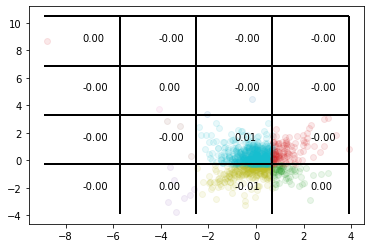

L1 : 0.0298 umbral 0.1471
son independientes
0.5770780163555853
0.015625


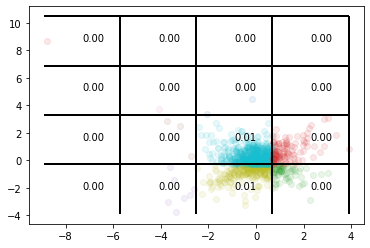

double exponential
I1 : 0.0417 umbral 0.1242
son independientes
Condicion : 0.1085


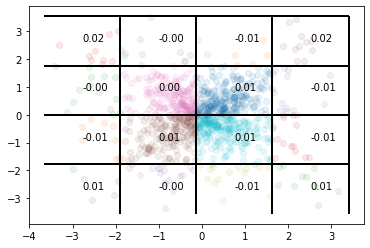

L1 : 0.1114 umbral 0.1471
son independientes
0.5770780163555853
0.015625


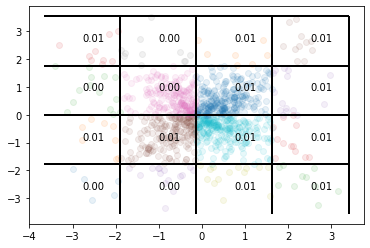

uniform
I1 : 0.4387 umbral 0.1242
son dependientes
Condicion : 0.1085


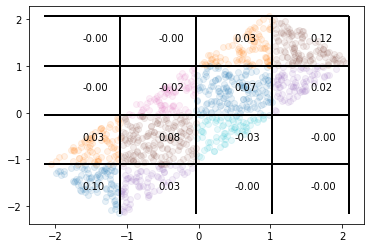

L1 : 0.6958 umbral 0.1471
son dependientes
0.5770780163555853
0.015625


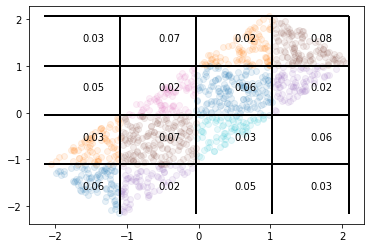

t-student
I1 : 0.0256 umbral 0.1242
son independientes
Condicion : 0.1085


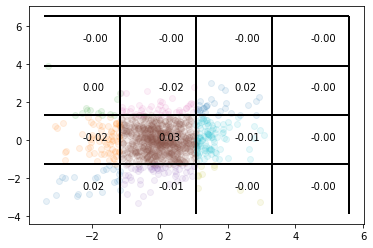

L1 : 0.1336 umbral 0.1471
son independientes
0.5770780163555853
0.015625


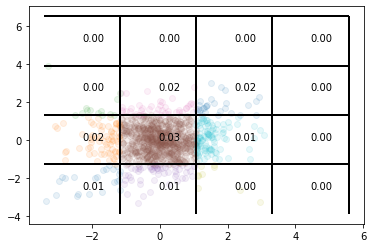

exponential
I1 : 0.0879 umbral 0.1242
son independientes
Condicion : 0.1085


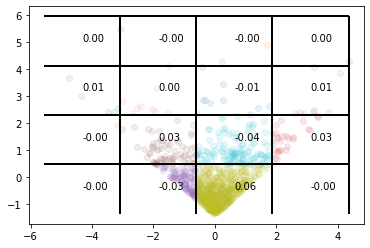

L1 : 0.2427 umbral 0.1471
son dependientes
0.5770780163555853
0.015625


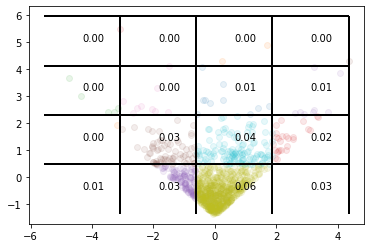

normal
I1 : 0.1041 umbral 0.1242
son independientes
Condicion : 0.1085


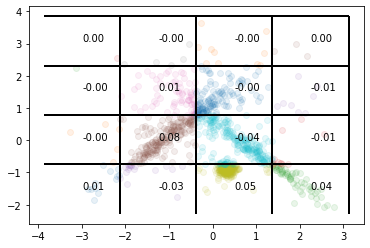

L1 : 0.3262 umbral 0.1471
son dependientes
0.5770780163555853
0.015625


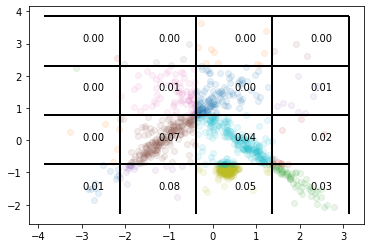

normal
I1 : 0.1170 umbral 0.1242
son independientes
Condicion : 0.1085


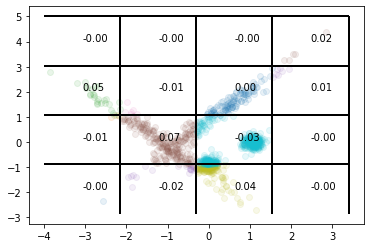

L1 : 0.2569 umbral 0.1471
son dependientes
0.5770780163555853
0.015625


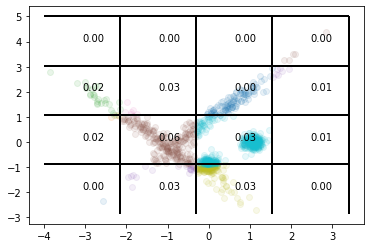

normal
I1 : 0.1692 umbral 0.1242
son dependientes
Condicion : 0.1085


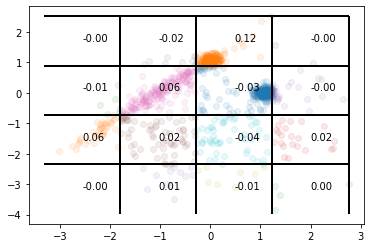

L1 : 0.4168 umbral 0.1471
son dependientes
0.5770780163555853
0.015625


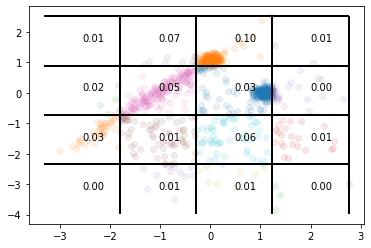

In [7]:
distributions = [
    ['t-student', np.random.standard_t,
     [{'df': 3}],
     [{'df': 3}]],
    ['double exponential', np.random.laplace,
     [{'loc':3, 'scale':1}],
     [{'loc':3, 'scale':1}]],
    ['uniform', np.random.uniform,
     [{'low': -3, 'high': 3}],
     [{'low': -1, 'high': 1}]],
    ['t-student', np.random.standard_t,
     [{'df': 5}],
     [{'df': 5}]],
    ['exponential', np.random.exponential,
     [{'scale': 1/6}],
     [{'scale': 1/6}]],
#     ['double exponential', np.random.laplace,
#      [{'loc':10, 'scale':1},
#       {'loc': 2, 'scale':1}],
#      [{'loc':10, 'scale':1},
#       {'loc': 2, 'scale':1}]],
    ['normal', np.random.normal,
     [{'loc':-2, 'scale': 0.5},
      {'loc': 2, 'scale': 0.5},
      {'loc':-2, 'scale': 5},
      {'loc': 2, 'scale': 5}],
     [{'loc':-4, 'scale': 0.5},
      {'loc':-4, 'scale': 5},
      {'loc': 4, 'scale': 0.5},
      {'loc': 4, 'scale': 5}]],
    ['normal', np.random.normal,
     [{'loc':-2, 'scale': 0.5},
      {'loc': 3, 'scale': 0.5},
      {'loc':-3, 'scale': 0.5},
      {'loc': 2, 'scale': 5}],
     [{'loc':-2, 'scale': 0.5},
      {'loc':-3, 'scale': 0.5},
      {'loc': 3, 'scale': 5},
      {'loc': 2, 'scale': 0.5}]],
    ['normal', np.random.normal,
     [{'loc':-5, 'scale': 5},
      {'loc': 2, 'scale': 0.5},
      {'loc':-5, 'scale': 5},
      {'loc': 2, 'scale': 0.5}],
     [{'loc':-5, 'scale': 5},
      {'loc':-5, 'scale': 0.5},
      {'loc': 2, 'scale': 0.5},
      {'loc': 2, 'scale': 0.5}]],
#     ['chisquare', np.random.chisquare,
#      [{'df': 3},
#       {'df': 2},
#       {'df': 4},
#       {'df': 2}],
#      [{'df': 3},
#       {'df': 2},
#       {'df': 4},
#       {'df': 2}]],
]


for name, distribution, paramsX, paramsY in distributions:
    print('{}'.format(name))
    theta = 0.8
    rotationMatrix = np.array([[np.cos(theta), -np.sin(theta)],
                               [np.sin(theta), np.cos(theta)]])

    X = samplear(distribution, paramsX)
    Y = samplear(distribution, paramsY)

    [X, Y] = rotationMatrix @ [X, Y]

    I1, umbral = logLikTest(X, Y, 4, 4, plotear=True)
    L1, umbral = l1Test(X, Y, 4, 4, plotear=True)

t-student
 theta : 0.7854 || iter :   40
double exponential
 theta : 0.7854 || iter :   40
uniform
 theta : 0.7854 || iter :   40
t-student
 theta : 0.7854 || iter :   40
exponential
 theta : 0.7854 || iter :   40
normal
 theta : 0.7854 || iter :   40
normal
 theta : 0.7854 || iter :   40
normal
 theta : 0.7854 || iter :   40


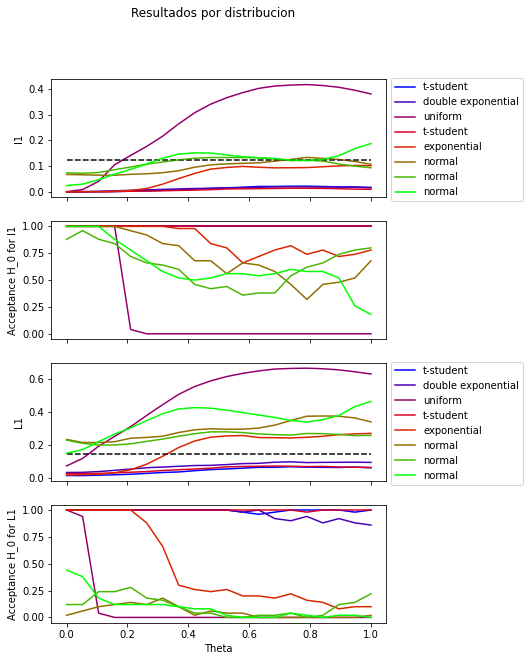

In [8]:
L1 = []
umbralL1 = []
acceptanceL1 = []
I1 = []
umbralI1 = []
acceptanceI1 = []

fig, axs = plt.subplots(4, sharex=True, figsize=(6,10))
fig.suptitle('Resultados por distribucion')
axs[0].set_ylabel('I1')
axs[1].set_ylabel('Acceptance H_0 for I1')
axs[2].set_ylabel('L1')
axs[3].set_ylabel('Acceptance H_0 for L1')
axs[3].set_xlabel('Theta')

colors = cm.brg(np.linspace(0, 1, len(distributions)))
labels = []
i = 0

for name, distribution, paramsX, paramsY in distributions:
    print('{}'.format(name))
    labels.append(name)
    [L1_, uL1, accL1, I1_, uI1, accI1] = run(distribution, paramsX, paramsY)

    axs[0].plot(Theta, I1_, ls='solid', color=colors[i], label=name)
    axs[0].plot(Theta, uI1, ls='dashed', c='k', alpha=0.2)
    axs[1].plot(Theta, accI1, color=colors[i])

    axs[2].plot(Theta, L1_, ls='solid', color=colors[i], label=name)
    axs[2].plot(Theta, uL1, ls='dashed', c='k', alpha=0.2)
    axs[3].plot(Theta, accL1, color=colors[i])

    i += 1
    
    L1.append(L1_)
    umbralL1.append(uL1)
    acceptanceL1.append(accL1)
    I1.append(I1_)
    umbralI1.append(uI1)
    acceptanceI1.append(accI1)
    print()

axs[0].legend(bbox_to_anchor=(1, 1.05))
axs[2].legend(bbox_to_anchor=(1, 1.05))
plt.show()

L1 = np.array(L1)
umbralL1 = np.array(umbralL1)
acceptanceL1 = np.array(acceptanceL1)
L1 = np.mean(L1, axis=0)
umbralL1 = np.mean(umbralL1, axis=0)
acceptanceL1 = np.mean(acceptanceL1, axis=0)

I1 = np.array(I1)
umbralI1 = np.array(umbralI1)
acceptanceI1 = np.array(acceptanceI1)
I1 = np.mean(I1, axis=0)
umbralI1 = np.mean(umbralI1, axis=0)
acceptanceI1 = np.mean(acceptanceI1, axis=0)
    


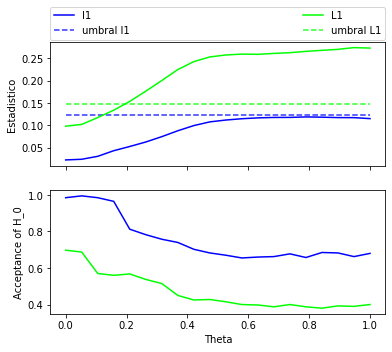

In [25]:
fig, axs = plt.subplots(2, sharex=True, figsize=(6,5))
# fig.suptitle('Resultados agregados')
axs[0].set_ylabel('Estadistico')
axs[1].set_ylabel('Acceptance of H_0')
axs[1].set_xlabel('Theta')

axs[0].plot(Theta, I1, label='I1', color=colors[0])
axs[0].plot(Theta, umbralI1, label='umbral I1', ls='dashed', color=colors[0], alpha=0.8)
axs[1].plot(Theta, acceptanceI1, color=colors[0])

axs[0].plot(Theta, L1, label='L1', color=colors[-1])
axs[0].plot(Theta, umbralL1, label='umbral L1', ls='dashed', color=colors[-1], alpha=0.8)
axs[1].plot(Theta, acceptanceL1, color=colors[-1])

axs[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
# axs[1].legend()
plt.show()

(1024,)


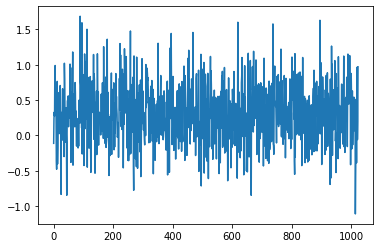

([<matplotlib.lines.Line2D at 0x7f06bab300a0>], None)

In [10]:
distribution = np.random.normal
params = [{'loc': 0.3, 'scale': 0.4},
          {'loc': 0.3, 'scale': 0.4}]

x = samplear(distribution, params)
print(x.shape)
plt.plot(x), plt.show()

In [11]:
aa = []
aa.append(np.array([1, 2, 3, 4]))
aa.append(np.array([1, 2, 3, 4]))
aa = np.array(aa)

print(np.mean(aa, axis=0))

[1. 2. 3. 4.]
